<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Wikidata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wikidata


In [ ]:
!pip install wikidata --quiet

Let's see how you can access the wikidata page of an item in order to extract relevant information to base your heuristics on.

First of all let's start from a wikidata page, in this case i selected the page for "bread"

In [ ]:
def extract_entity_id(url):
    return url.strip().split("/")[-1]

wikidata_url = "https://www.wikidata.org/wiki/Q7802"
entity_id = extract_entity_id(wikidata_url)
#entity_id = "Q7802"
print("Entity ID:", entity_id)

Entity ID: Q7802


Let's start extracting information from this item.
Right now we only hvae the link to it. Just like you will have in your dev set.
But we don't even know the name of the item yet.
To print it we need to first query the entity using the client class in wikidata.client and then print the item's label.

In [ ]:
from wikidata.client import Client

client = Client()
item = client.get(entity_id, load=True)
print(item.label)

bread


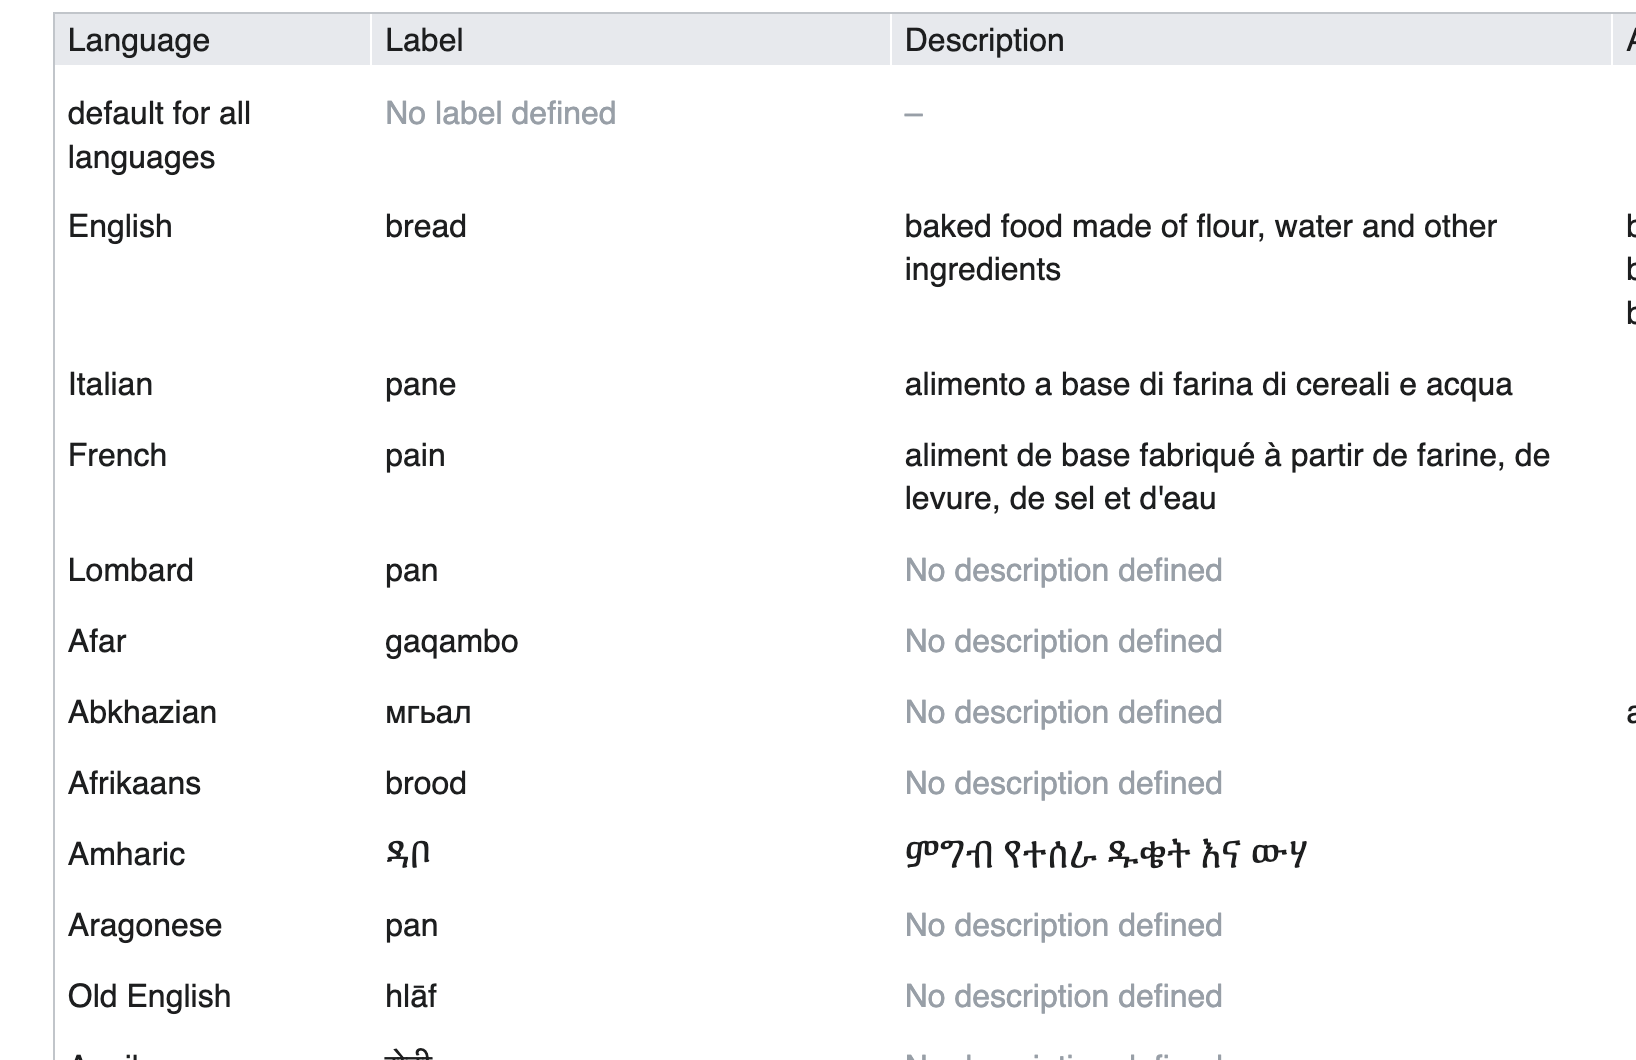

We may, for example, want to print "bread" in all the languages. Or at least in all the languages that it's in




In [ ]:
from itertools import islice

#we can use get on the "data" because it's a python dictionary

labels = item.data.get("labels",{})

print(f"{len(labels)}")
for lang, label in islice(labels.items(),5):
  print(f"{label}")

280
{'language': 'it', 'value': 'pane'}
{'language': 'fr', 'value': 'pain'}
{'language': 'en', 'value': 'bread'}
{'language': 'en-ca', 'value': 'bread'}
{'language': 'en-gb', 'value': 'bread'}


Label, like many other important informations that we will extract from the
wikidata page is in jsonfile format. In this case "label" is a dictionary containing "langugage" and "value" which indicate the language and the actual label in that language

In [ ]:
for lang, label in islice(labels.items(),5):
  print(f"{label['language']}:{label['value']}")

it:pane
fr:pain
en:bread
en-ca:bread
en-gb:bread


Same thing goes for the descriptions

In [ ]:

description = item.data.get("descriptions",{})

print(f"{len(description.items())}")
for lang,desc in islice(description.items(),5):
  print(f"{lang}:{desc['value']}")

62
it:alimento a base di farina di cereali e acqua
fr:aliment de base fabriqué à partir de farine, de levure, de sel et d'eau
es:alimento elaborado con harina de trigo
en:baked food made of flour, water and other ingredients
de:Nahrungsmittel, das aus Mehl, Wasser und weiteren Zutaten gebacken wird


Now let's start extracting the relationships. In wikidata what we know as a "relationship" is known as "claim"
To extract claims we actually have to access the raw data of the item json file,

In [ ]:
claims = item.data.get("claims", {})

print(f"{len(claims)}")
for claim in islice(claims.items(),10):
  print(f"{claim}")

107
('P487', [{'mainsnak': {'snaktype': 'value', 'property': 'P487', 'hash': 'af7c535d7a5929be1ae429ea3847fa5acb468611', 'datavalue': {'value': '🍞', 'type': 'string'}, 'datatype': 'string'}, 'type': 'statement', 'id': 'q7802$b4c18a4b-49e7-9b52-26bd-9178f147af56', 'rank': 'normal'}])
('P373', [{'mainsnak': {'snaktype': 'value', 'property': 'P373', 'hash': '3d36ede6e3f9c264024b342dfaea71392eec22f1', 'datavalue': {'value': 'Bread', 'type': 'string'}, 'datatype': 'string'}, 'type': 'statement', 'id': 'q7802$7C21EF8B-E83C-4F43-B33A-2CEBFCD2517B', 'rank': 'normal'}])
('P508', [{'mainsnak': {'snaktype': 'value', 'property': 'P508', 'hash': 'c8df85379d3be2296967058733af9b1aaffa9a94', 'datavalue': {'value': '6169', 'type': 'string'}, 'datatype': 'external-id'}, 'type': 'statement', 'id': 'q7802$F5034551-7BAC-41A3-9C7B-2280DCC645BE', 'rank': 'normal', 'references': [{'hash': 'ff65511d37e885bcf005b99c2241192548c3f03a', 'snaks': {'P248': [{'snaktype': 'value', 'property': 'P248', 'hash': '3b090a7b

As you can see the first element of this tuple is the id of the relationship.
The relationship tags are wikidata pages as well and you should explore them in detail.

Now of course we may want to know this id's actual name. So that we can have a clear idea of which claims belong to our item.



In [ ]:
for prop_id, values in islice(claims.items(), 10):
  prop_entity = client.get(prop_id, load=True) #one call for each id
  label = prop_entity.label
  print(f"{prop_id} = {label} ({len(values)} statement{'s' if len(values) != 1 else ''})") #this part "statement{'s' if len(values) != 1 else ''} is just to put the "s" at the end of statements

P487 = Unicode character (1 statement)
P373 = Commons category (1 statement)
P508 = BNCF Thesaurus ID (1 statement)
P910 = topic's main category (1 statement)
P349 = NDL Authority ID (1 statement)
P935 = Commons gallery (1 statement)
P646 = Freebase ID (1 statement)
P227 = GND ID (1 statement)
P443 = pronunciation audio (4 statements)
P1051 = PSH ID (1 statement)


Now let's say we want to exploit the content of one of these statements.
Let's take P487 "Unicode character"

In [ ]:
claims = item.data.get("claims", {})
proposition = claims.get("P487")
print(f"{(proposition)}")


[{'mainsnak': {'snaktype': 'value', 'property': 'P487', 'hash': 'af7c535d7a5929be1ae429ea3847fa5acb468611', 'datavalue': {'value': '🍞', 'type': 'string'}, 'datatype': 'string'}, 'type': 'statement', 'id': 'q7802$b4c18a4b-49e7-9b52-26bd-9178f147af56', 'rank': 'normal'}]


we should go into mainsnak, datavalue and then value



In [ ]:
unicode_statements = claims.get("P487", [])

print("Values for 'Unicode character' (P487):")
for statement in unicode_statements:
  mainsnak = statement.get("mainsnak", {})
  datavalue = mainsnak.get("datavalue", {})
  value = datavalue.get("value")
  if value:
    print("bread: ", value)

Values for 'Unicode character' (P487):
bread:  🍞


In [ ]:
sitelinks = item.data.get("sitelinks", {})
print(sitelinks)

{'afwiki': {'site': 'afwiki', 'title': 'Brood', 'badges': [], 'url': 'https://af.wikipedia.org/wiki/Brood'}, 'alswiki': {'site': 'alswiki', 'title': 'Brot', 'badges': [], 'url': 'https://als.wikipedia.org/wiki/Brot'}, 'amwiki': {'site': 'amwiki', 'title': 'ዳቦ', 'badges': [], 'url': 'https://am.wikipedia.org/wiki/%E1%8B%B3%E1%89%A6'}, 'angwiki': {'site': 'angwiki', 'title': 'Hlāf', 'badges': [], 'url': 'https://ang.wikipedia.org/wiki/Hl%C4%81f'}, 'anpwiki': {'site': 'anpwiki', 'title': 'रोटी', 'badges': [], 'url': 'https://anp.wikipedia.org/wiki/%E0%A4%B0%E0%A5%8B%E0%A4%9F%E0%A5%80'}, 'anwiki': {'site': 'anwiki', 'title': 'Pan', 'badges': [], 'url': 'https://an.wikipedia.org/wiki/Pan'}, 'arwiki': {'site': 'arwiki', 'title': 'خبز', 'badges': [], 'url': 'https://ar.wikipedia.org/wiki/%D8%AE%D8%A8%D8%B2'}, 'arzwiki': {'site': 'arzwiki', 'title': 'عيش', 'badges': [], 'url': 'https://arz.wikipedia.org/wiki/%D8%B9%D9%8A%D8%B4'}, 'astwiki': {'site': 'astwiki', 'title': 'Pan', 'badges': ['Q1743

In [ ]:

# Filter only Wikipedia sitelinks and print them
print("Wikipedia pages available for this entity:\n")

for site_key, site_data in sitelinks.items():
    if site_key.endswith("wiki") and not site_key.startswith("commons"):
        lang = site_key.replace("wiki", "")
        title = site_data["title"]
        url = f"https://{lang}.wikipedia.org/wiki/{title.replace(' ', '_')}"
        print(f"{lang}: {url}")

Wikipedia pages available for this entity:

af: https://af.wikipedia.org/wiki/Brood
als: https://als.wikipedia.org/wiki/Brot
am: https://am.wikipedia.org/wiki/ዳቦ
ang: https://ang.wikipedia.org/wiki/Hlāf
anp: https://anp.wikipedia.org/wiki/रोटी
an: https://an.wikipedia.org/wiki/Pan
ar: https://ar.wikipedia.org/wiki/خبز
arz: https://arz.wikipedia.org/wiki/عيش
ast: https://ast.wikipedia.org/wiki/Pan
as: https://as.wikipedia.org/wiki/পাউৰুটী
atj: https://atj.wikipedia.org/wiki/Tcipa
awa: https://awa.wikipedia.org/wiki/डबलरोटी
ay: https://ay.wikipedia.org/wiki/T'ant'a
azb: https://azb.wikipedia.org/wiki/چؤرک
az: https://az.wikipedia.org/wiki/Çörək
bar: https://bar.wikipedia.org/wiki/Brod
bat_smg: https://bat_smg.wikipedia.org/wiki/Douna
ba: https://ba.wikipedia.org/wiki/Икмәк
bcl: https://bcl.wikipedia.org/wiki/Tinapay
be_x_old: https://be_x_old.wikipedia.org/wiki/Хлеб
be: https://be.wikipedia.org/wiki/Хлеб
bew: https://bew.wikipedia.org/wiki/Roti
bg: https://bg.wikipedia.org/wiki/Хляб
bjn:

That's a lot of wikipedia pages. But you'll always find the english one

In [ ]:
# Get entity
wikidata_url = "https://www.wikidata.org/wiki/Q7802"
entity_id = extract_entity_id(wikidata_url)
item = client.get(entity_id, load=True)
print(item.label)

bread


In [ ]:

#getting the url
sitelinks = item.data.get("sitelinks", {})
enwiki = sitelinks.get("enwiki")
print(enwiki.get("url"))

https://en.wikipedia.org/wiki/Bread


In [ ]:
import requests
from wikidata.client import Client

if enwiki:
    title = enwiki["title"]
    print("english wikipedia title:", title)

    # Use Wikipedia's API to get plain text of the article
    api_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "prop": "extracts",
        "explaintext": True,
        "titles": title,
        "format": "json",
        "redirects": 1
    }

    res = requests.get(api_url, params=params).json()
    page = next(iter(res["query"]["pages"].values())) #see below the dictionary, we create an iterable and pick the first and only item
    text = page.get("extract", "") # we get the "extract field"

    # Print just the first 1000 characters
    print("\nfirst 1000 characters:\n")
    print(text[:1000])

else:
    print("no enwiki page found for this entity")

english wikipedia title: Bread

first 1000 characters:

Bread is a staple food prepared from a dough of flour (usually wheat) and water, usually by baking. Throughout recorded history and around the world, it has been an important part of many cultures' diets. It is one of the oldest human-made foods, having been of significance since the dawn of agriculture, and plays an essential role in both religious rituals and secular culture.
Bread may be leavened by naturally occurring microbes (e.g. sourdough), chemicals (e.g. baking soda), industrially produced yeast, or high-pressure aeration, which creates the gas bubbles that fluff up bread. Bread may also be unleavened. In many countries, mass-produced bread often contains additives to improve flavor, texture, color, shelf life, nutrition, and ease of production.


== Etymology ==
The Old English word for bread was hlaf (hlaifs in Gothic: modern English loaf) which appears to be the oldest Teutonic name. Old High German hleib and modern G

```

{
  "query": {
    "pages": {
      "177": {
        "pageid": 177,
        "ns": 0,
        "title": "Pizza",
        "extract": "Bread is a thing made of blah blah..."
      }
    }
  }
}

```



In [ ]:
# words we want to count
keywords = ["italy", "italian", "traditional"]

# make text lowercase so search is case-insensitive
text_lower = text.lower()

# count how many times each word shows up
print("\nKeyword counts:")
for word in keywords:
    count = text_lower.count(word)
    print(f"{word}: {count}")


Keyword counts:
italy: 0
italian: 0
traditional: 3


In [ ]:
import requests
from wikidata.client import Client

#Setup Wikidata client
client = Client()

# Piza entity
wikidata_url = "https://www.wikidata.org/wiki/Q177"
entity_id = extract_entity_id("Q177")
item = client.get(entity_id, load=True)

#   Get English Wikipedia sitelink
sitelinks = item.data.get("sitelinks", {})
enwiki = sitelinks.get("enwiki")

if enwiki:
    title = enwiki["title"]
    print("english wikipedia title:", title)

    #Use Wikipedia API to get plaintext
    api_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "prop": "extracts",
        "explaintext": True, #we just want the readable text
        "titles": title,
        "format": "json",
        "redirects": 1
    }

    res = requests.get(api_url, params=params).json()
    page = next(iter(res["query"]["pages"].values())) # see below
    text = page.get("extract", "")

    # Show the first 1000 characters
    print("\nFirst 1000 characters:\n")
    print(text[:1000])

    # Keyword counts
    keywords = ["italy", "italian", "traditional"]
    text_lower = text.lower()

    print("\nKeyword counts:")
    for word in keywords:
        count = text_lower.count(word)
        print(f"{word}: {count}")
else:
    print("No English Wikipedia page found for this entity.")

english wikipedia title: Pizza

First 1000 characters:

Pizza is an Italian, specifically Neapolitan, dish typically consisting of a flat base of leavened wheat-based dough topped with tomato, cheese, and other ingredients, baked at a high temperature, traditionally in a wood-fired oven.
The term pizza was first recorded in 997 AD, in a Latin manuscript from the southern Italian town of Gaeta, in Lazio, on the border with Campania. Raffaele Esposito is often credited for creating the modern pizza in Naples. In 2009, Neapolitan pizza was registered with the European Union as a traditional speciality guaranteed (TSG) dish. In 2017, the art of making Neapolitan pizza was included on UNESCO's list of intangible cultural heritage.
Pizza and its variants are among the most popular foods in the world. Pizza is sold at a variety of restaurants, including pizzerias (pizza specialty restaurants), Mediterranean restaurants, via delivery, and as street food. In Italy, pizza served in a restaurant 